In [1]:
from __future__ import annotations

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from carps.analysis.process_data import get_interpolated_performance_df, load_logs


def print_overview(df_trials: pd.DataFrame) -> None:
    print(df_trials.columns)
    print(df_trials["optimizer_id"].unique())
    print(df_trials["benchmark_id"].unique())
    print(df_trials["problem_id"].unique())
    print("Number of seeds", df_trials["seed"].nunique())


rundir = "/home/numina/Documents/repos/CARP-S-Experiments/lib/CARP-S/runs"

df, df_cfg = load_logs(rundir=rundir)
print_overview(df)
perf = get_interpolated_performance_df(df)

[13:30:08] INFO     Load logs from                                                               ]8;id=987560;file:///home/numina/Documents/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/process_data.py\process_data.py]8;;\:]8;id=779359;file:///home/numina/Documents/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/process_data.py#80\80]8;;\
                    `/home/numina/Documents/repos/CARP-S-Experiments/lib/CARP-S/runs/logs.csv`                     
                    and associated configs from                                                                    
                    /home/numina/Documents/repos/CARP-S-Experiments/lib/CARP-S/runs/logs_cfg.csv                   
                    . Preprocess logs.                                                                             

           INFO     Processing raw logs. Normalize n_trials and costs. Calculate trajectory      ]8;id=299732;file:///home/numina/Documents/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/process_data.py\process_data.py]8;;\:]8;id=223365;file:///home/numina/Documents/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/process_data.py#14\14]8;;\
                    (incumbent cost).                                                                              

Index(['n_trials', 'trial_info__config', 'trial_info__instance',
       'trial_info__seed', 'trial_info__budget', 'trial_info__name',
       'trial_info__checkpoint', 'trial_value__cost', 'trial_value__time',
       'trial_value__virtual_time', 'trial_value__status',
       'trial_value__starttime', 'trial_value__endtime', 'seed',
       'benchmark_id', 'problem_id', 'optimizer_id', 'problem.bench',
       'problem.instance', 'problem.budget_type', 'problem.metric',
       'problem.dimension', 'problem.fid', 'problem.seed', 'experiment_id',
       'n_trials_norm', 'trial_value__cost_norm', 'trial_value__cost_inc',
       'trial_value__cost_inc_norm'],
      dtype='object')
['SyneTune-BO' 'SMAC3-BlackBoxFacade' 'RandomSearch']
['YAHPO' 'BBOB']
['yahpo/so/lcbench/167168/None' 'noiseless/4/1/0'
 'yahpo/so/rbv2_rpart/40499/None' 'yahpo/so/rbv2_rpart/14/None'
 'yahpo/so/rbv2_ranger/16/None' 'yahpo/so/rbv2_ranger/42/None'
 'yahpo/so/rbv2_super/1468/None' 'yahpo/so/rbv2_super/1457/None'
 'yah

           INFO     Create dataframe for neat plotting by aligning x-axis / interpolating        ]8;id=960985;file:///home/numina/Documents/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/process_data.py\process_data.py]8;;\:]8;id=601669;file:///home/numina/Documents/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/process_data.py#50\50]8;;\
                    budget.                                                                                        

In [2]:
from carps.analysis.interval_estimates import plot_interval_estimates

fig, axes = plot_interval_estimates(performance_data=perf, load_from_pickle=False, figure_filename="figures/plot_interval_estimates.pdf")

[13:30:16] INFO     Nothing found for noiseless/4/1/0 in config path                           ]8;id=707987;file:///home/numina/Documents/repos/CARP-S-Experiments/lib/CARP-S/carps/utils/overridefinder.py\overridefinder.py]8;;\:]8;id=945140;file:///home/numina/Documents/repos/CARP-S-Experiments/lib/CARP-S/carps/utils/overridefinder.py#35\35]8;;\
                    /home/numina/Documents/repos/CARP-S-Experiments/lib/CARP-S/carps/configs/p                     
                    roblem                                                                                         

seed=1,2,3,4,5,6,7,8,9,10 +problem=YAHPO/SO/cfg_lcbench_167168 +optimizer=randomsearch/config
seed=2,3,4,5,6,7,8,9,10 +problem= +optimizer=smac20/blackbox


[13:32:00] INFO     Nothing found for noiseless/4/1/0 in config path                           ]8;id=551655;file:///home/numina/Documents/repos/CARP-S-Experiments/lib/CARP-S/carps/utils/overridefinder.py\overridefinder.py]8;;\:]8;id=963379;file:///home/numina/Documents/repos/CARP-S-Experiments/lib/CARP-S/carps/utils/overridefinder.py#35\35]8;;\
                    /home/numina/Documents/repos/CARP-S-Experiments/lib/CARP-S/carps/configs/p                     
                    roblem                                                                                         

seed=3,6,7,8,9,10 +problem= +optimizer=synetune/BO


[13:32:49] INFO     Dropped following incomplete methods:                                  ]8;id=189521;file:///home/numina/Documents/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/interval_estimates.py\interval_estimates.py]8;;\:]8;id=616870;file:///home/numina/Documents/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/interval_estimates.py#95\95]8;;\

           INFO     {                                                                      ]8;id=992491;file:///home/numina/Documents/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/interval_estimates.py\interval_estimates.py]8;;\:]8;id=473283;file:///home/numina/Documents/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/interval_estimates.py#96\96]8;;\
                            "incomplete": [                                                                        
                                    {                                                                              
                                            "method": "RandomSearch",                                              
                                            "missing_seeds": [],                                                   
                                            "missing_instances": [                                                 
                                                    "noiseless/4/1/0",                                             
                                                    "yahpo/so/lcbench/167168/None"                                 
                                            ]                                                                      
                                    },                                                                             
                                    {                                                                              
                                            "method": "SMAC3-BlackBoxFacade",                                      
                                            "missing_seeds": [                                                     
                                                    2,                                                             
                                                    3,                                                             
                                                    4,                                                             
                                                    5,                                                             
                                                    6,                                                             
                                                    7,                                                             
                                                    8,                                                             
                                                    9,                                                             
                                                    10                                                             
                                            ],                                                                     
                                            "missing_instances": [                                                 
                                                    "yahpo/so/rbv2_glmnet/375/None",                               
                                                    "yahpo/so/rbv2_ranger/16/None",                                
                                                    "yahpo/so/rbv2_super/1063/None",                               
                                                    "yahpo/so/rbv2_xgboost/40499/None",                            
                                                    "yahpo/so/rbv2_super/1479/None",                               
                                                    "yahpo/so/nb301/CIFAR10/None",                                 
                                                    "yahpo/so/rbv2_glmnet/458/None",                               
                                                    "yahpo/so/rbv2_super/1457/None",                               
                                   

           INFO     Overrides:                                                             ]8;id=792928;file:///home/numina/Documents/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/interval_estimates.py\interval_estimates.py]8;;\:]8;id=981366;file:///home/numina/Documents/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/interval_estimates.py#97\97]8;;\

           INFO     ['seed=1,2,3,4,5,6,7,8,9,10 +problem=YAHPO/SO/cfg_lcbench_167168       ]8;id=495263;file:///home/numina/Documents/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/interval_estimates.py\interval_estimates.py]8;;\:]8;id=674647;file:///home/numina/Documents/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/interval_estimates.py#98\98]8;;\
                    +optimizer=randomsearch/config', 'seed=2,3,4,5,6,7,8,9,10 +problem=                            
                    +optimizer=smac20/blackbox', 'seed=3,6,7,8,9,10 +problem=                                      
                    +optimizer=synetune/BO']                                                                       

{}
{}


IndexError: list index out of range

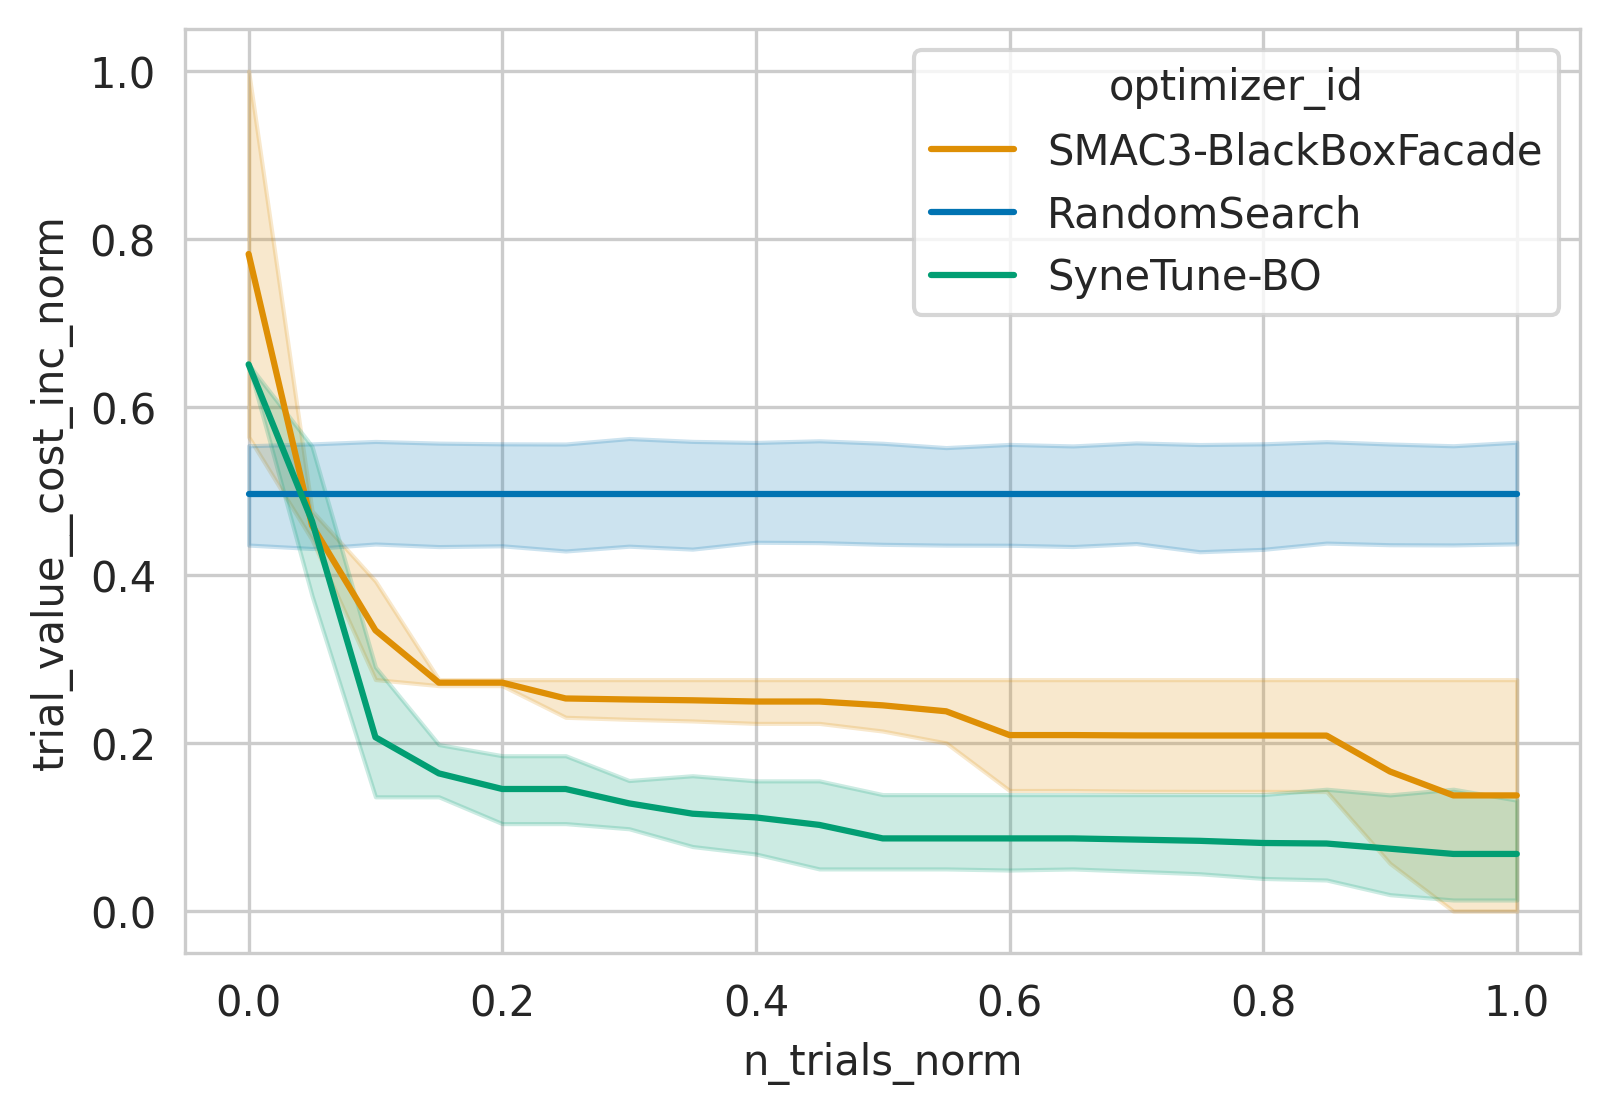

In [ ]:
from carps.analysis.performance_over_time import plot_performance_over_time
lineplot_kwargs = dict()
fig, ax = plot_performance_over_time(df=perf, x="n_trials_norm", y="trial_value__cost_inc_norm", hue="optimizer_id", figure_filename="figures/performance_over_time.pdf", figsize=(6,4), **lineplot_kwargs)

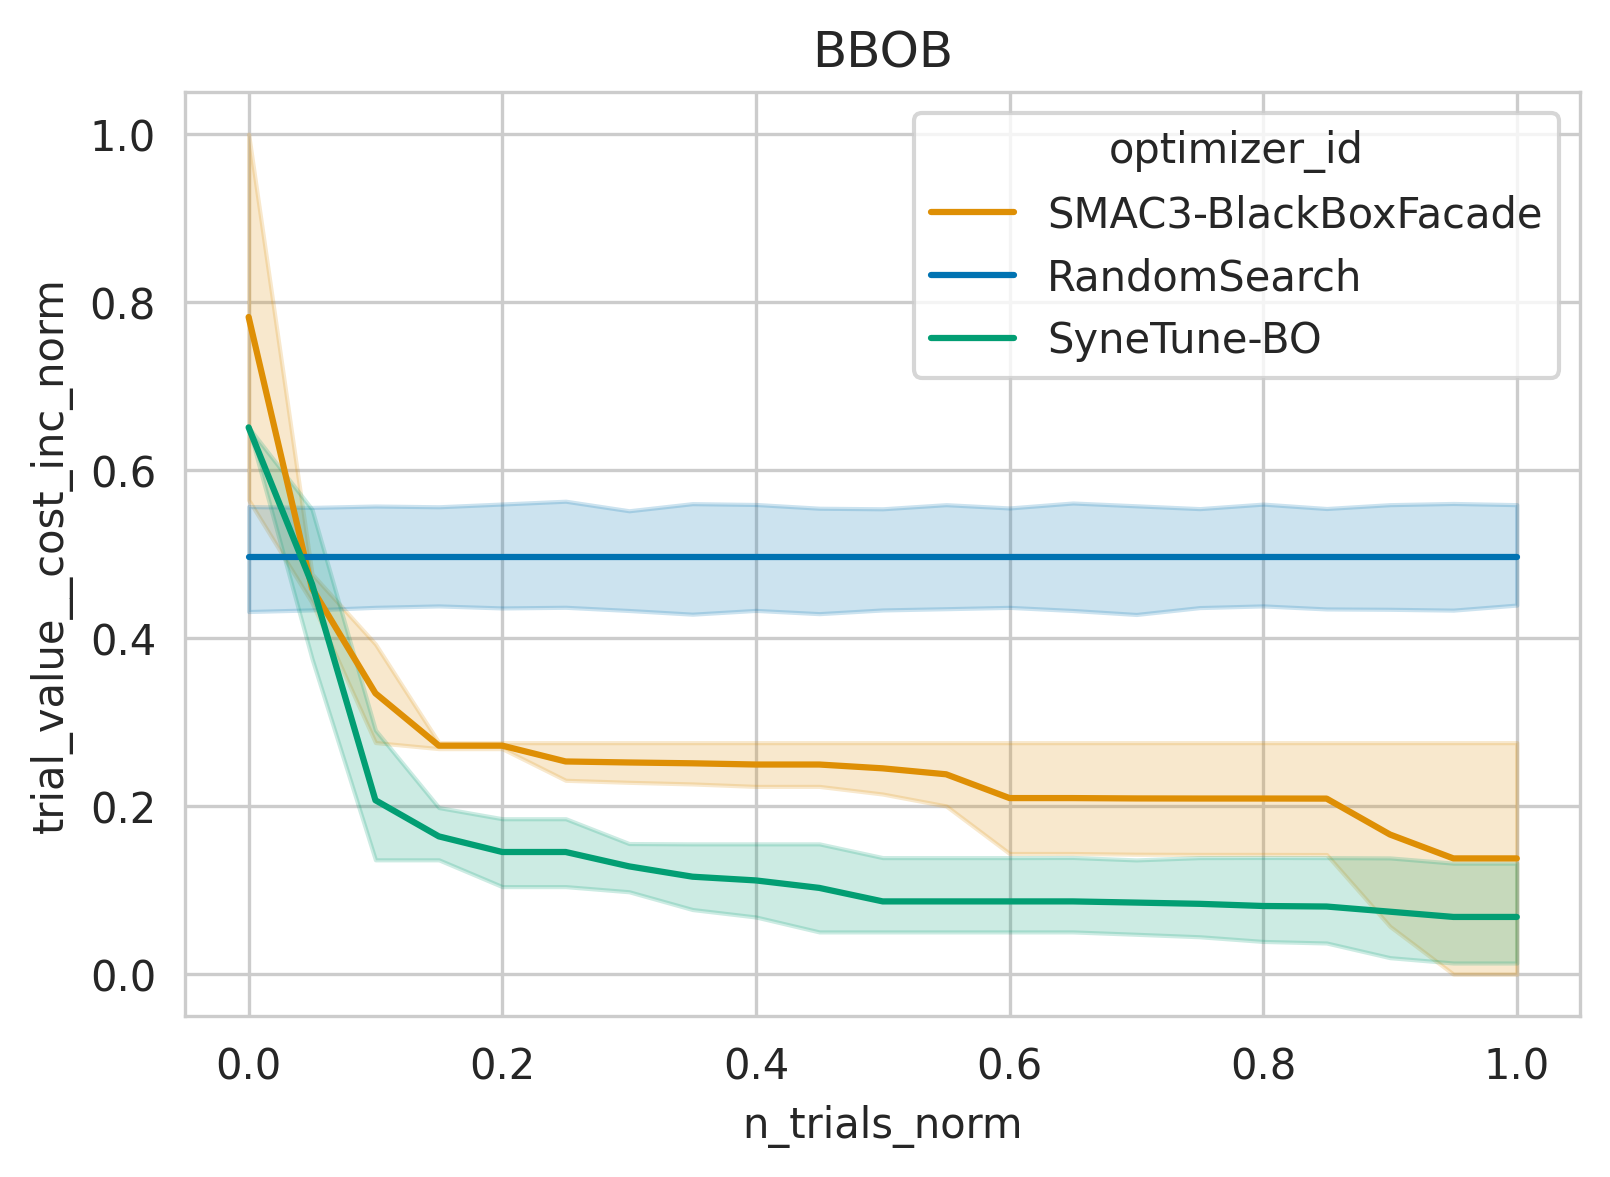

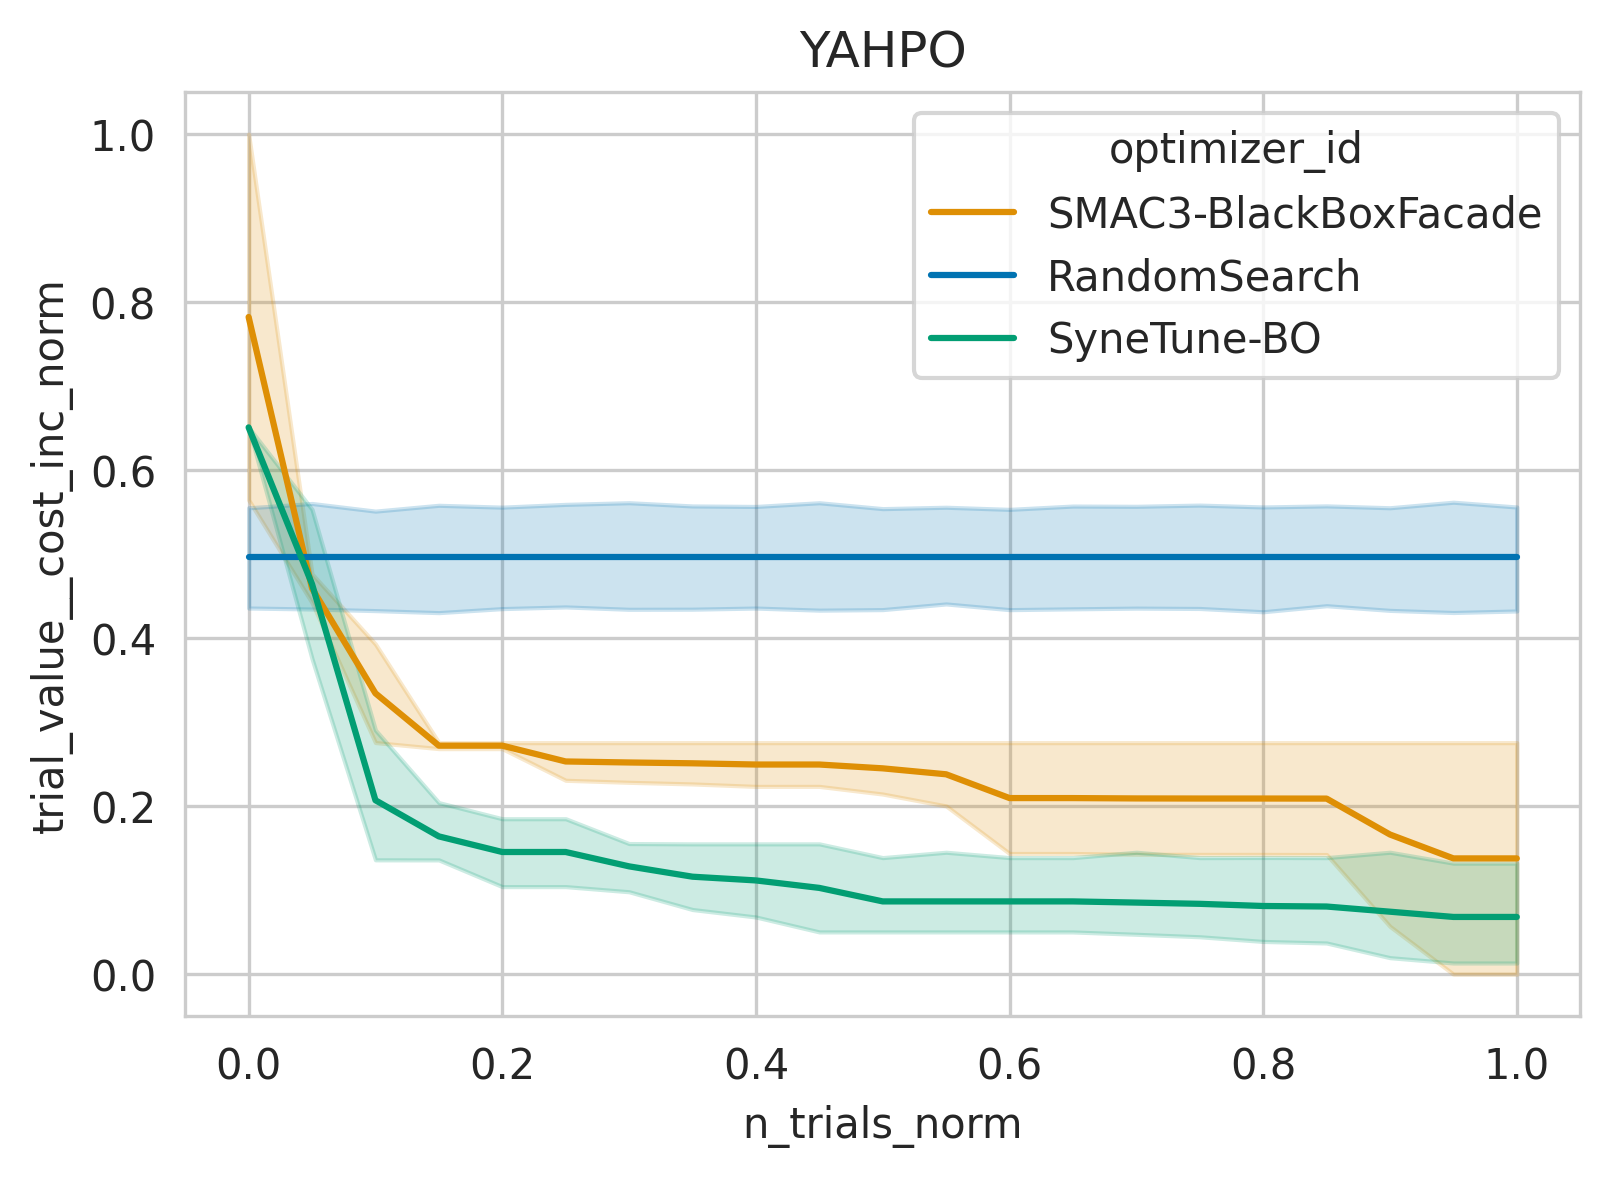

In [ ]:
# Plot per benchmark
from carps.analysis.utils import get_color_palette, savefig
from carps.analysis.performance_over_time import plot_performance_over_time

palette = get_color_palette(perf)
lineplot_kwargs = dict()
for gid, gdf in perf.groupby(by="benchmark_id"):    
    figure_filename = f"figures/performance_over_time_{gid}.pdf"
    fig, ax = plot_performance_over_time(df=perf, x="n_trials_norm", y="trial_value__cost_inc_norm", hue="optimizer_id", figure_filename=figure_filename, figsize=(6,4), **lineplot_kwargs)
    ax.set_title(gid)
    savefig(fig, figure_filename)
    plt.show()

NameError: name 'np' is not defined

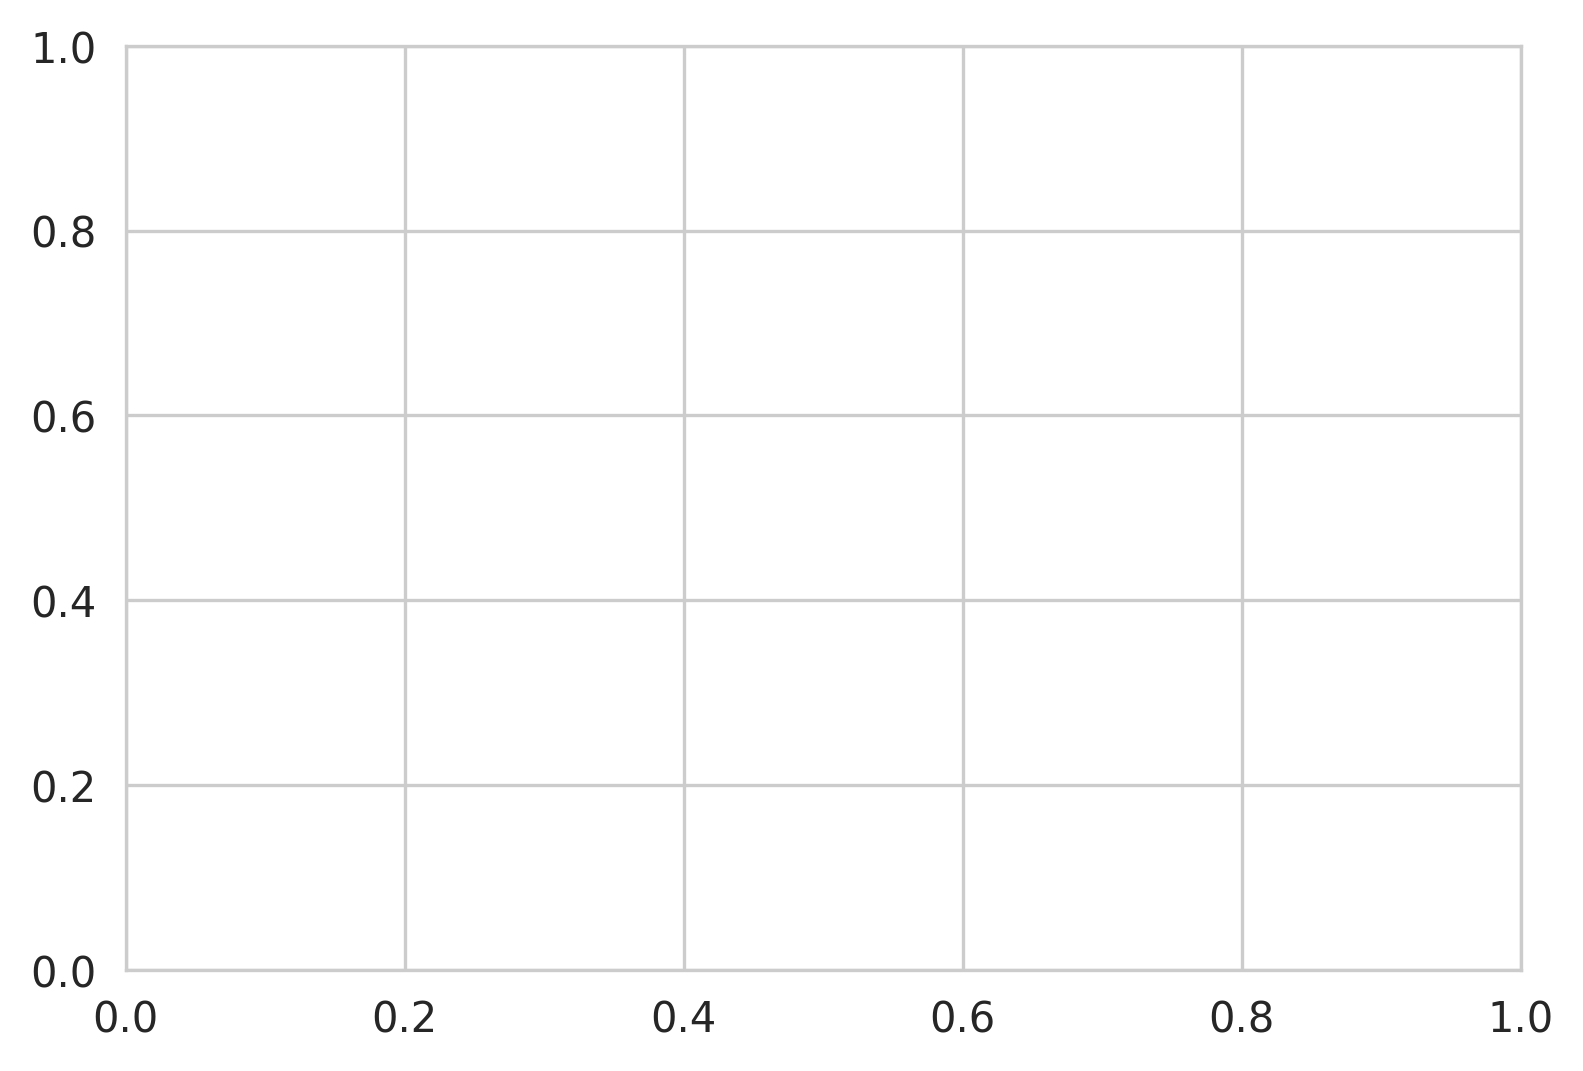

In [ ]:
from carps.analysis.final_performance import plot_final_performance_boxplot

boxplot_kwargs = dict()
fig, ax = plot_final_performance_boxplot(df=perf, x="trial_value__cost_inc_norm", y="optimizer_id", hue="optimizer_id", figure_filename="figures/final_performance_boxplot.pdf", figsize=(6,4), **boxplot_kwargs)

In [ ]:
max_val = df["n_trials_norm"].max()
error = df.groupby(by=["benchmark_id", "problem_id", "optimizer_id", "seed"])["n_trials_norm"].apply(lambda x: not np.isclose(x.max(), max_val))
error = error[error]
for i in error.index:
    print(i)

('YAHPO', 'yahpo/so/lcbench/167168/None', 'SMAC3-BlackBoxFacade', 1)
('YAHPO', 'yahpo/so/lcbench/167168/None', 'SyneTune-BO', 4)
('YAHPO', 'yahpo/so/lcbench/167168/None', 'SyneTune-BO', 5)
('YAHPO', 'yahpo/so/nb301/CIFAR10/None', 'RandomSearch', 1)
('YAHPO', 'yahpo/so/nb301/CIFAR10/None', 'RandomSearch', 2)
('YAHPO', 'yahpo/so/nb301/CIFAR10/None', 'RandomSearch', 3)
('YAHPO', 'yahpo/so/nb301/CIFAR10/None', 'RandomSearch', 4)
('YAHPO', 'yahpo/so/nb301/CIFAR10/None', 'RandomSearch', 5)
('YAHPO', 'yahpo/so/nb301/CIFAR10/None', 'RandomSearch', 6)
('YAHPO', 'yahpo/so/nb301/CIFAR10/None', 'RandomSearch', 7)
('YAHPO', 'yahpo/so/nb301/CIFAR10/None', 'RandomSearch', 8)
('YAHPO', 'yahpo/so/nb301/CIFAR10/None', 'RandomSearch', 9)
('YAHPO', 'yahpo/so/nb301/CIFAR10/None', 'RandomSearch', 10)
('YAHPO', 'yahpo/so/rbv2_glmnet/375/None', 'RandomSearch', 1)
('YAHPO', 'yahpo/so/rbv2_glmnet/375/None', 'RandomSearch', 2)
('YAHPO', 'yahpo/so/rbv2_glmnet/375/None', 'RandomSearch', 3)
('YAHPO', 'yahpo/so/rbv2